# Predicting House Prices in Ames, IA
<br>
<br>

This notebook contain my submission for the House Price Prediction competition on Kaggle. In this project I will take you through my process of cleaning the data and the decisions made in the process.

For the sake of brevity, some insights applied in the code are product of the hindsight when I notice something in the data that can be elegantly solved somewhere earlier in the process of creating this code.
<br>
<br>
#### Part 1: Loading and cleaning the data

Short section where I get the data ready for visualizations and feature creation/model building. This dataset is already highly curated, so the fixes were short.
<br>
<br>

#### Part 2: Visualization

Using the resulting data frame, I will create a few visualizations I think will help better show how the data relates to itself.
<br>
<br>

#### Part 3: Feature creation

Columns that can preserve their relation numerically will be coded and other will be made into dummies with each entry having a column/feature with a binary option. Monolithic, incomplete, or otherwise useless columns where the predictive power/data is present in another column.
<br>
<br>

#### Part 4: Modeling

Cross validation of the data to check for multicollinearity and ways to simplify the model. Two models will be created: A linear model to gain some insights into the coefficient affecting the depedent variable, and a XGBoost model to maximize the predictive power.

#### Part 1: Loading and cleaning the data

In [316]:
import pandas as pd
import numpy as np

%matplotlib inline

In [317]:
# Loading training data

dforigin = pd.read_csv("../train.csv")

dftrain = dforigin

In [318]:
# Premade script to comb through basic figures and pinpoint issues, nulls, usefulness of features

def eda(dataframe):
    temp_maxrows = pd.get_option("display.max_rows")
    pd.set_option("display.max_rows", None)
    print("missing values \n", dataframe.isnull().sum())
    print("dataframe index \n", dataframe.index)
    print("dataframe types \n", dataframe.dtypes)
    print("dataframe shape \n", dataframe.shape)
    print("dataframe describe \n", dataframe.describe())
    print("dataframe duplicates \n", dataframe.duplicated().sum()) 
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique())
    pd.set_option("display.max_rows", temp_maxrows)
        
eda(dftrain)

missing values 
 Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF       

In [319]:
# Secondary script to get more information on data types and size of features

def eda_helper(df):
    temp_maxrows = pd.get_option("display.max_rows")
    pd.set_option("display.max_rows", None)
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        dict_.update({"null_count" : data.isnull().sum()})
        dict_.update({"unique_count" : len(data.unique())})
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
    eda_df = eda_df.sort_values(['null_count','unique_count'], ascending=[True, False])
    return eda_df
    pd.set_option("display.max_rows", temp_maxrows)

eda_helper(dftrain)

,null_count,unique_count,data_type
Id,0,1460,{int}
LotArea,0,1073,{int}
GrLivArea,0,861,{int}
BsmtUnfSF,0,780,{int}
1stFlrSF,0,753,{int}
TotalBsmtSF,0,721,{int}
SalePrice,0,663,{int}
BsmtFinSF1,0,637,{int}
GarageArea,0,441,{int}
2ndFlrSF,0,417,{int}


In [320]:
""" Transforming and cleaning up the data"""

#Coding the ranked qualitative response into a quantitative, aka A,B,C become 3,2,1
scale_from_6 = sorted(list(range(6)), reverse=True)
rating_from_top = ['Ex','Gd','TA','Fa','Po', np.nan]
vars_to_scale = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

for i in vars_to_scale:
    dftrain[i].replace(rating_from_top, scale_from_6, inplace=True)


### BsmtExposure : Refers to walkout or garden level walls ###
#Coding rating to numeric
dftrain.BsmtExposure.replace(['Gd','Av','Mn','No', np.nan], [4, 3, 2, 1, 0], inplace=True)


### CentrailAir : Central air conditioning ###
#Converting to logistical response
dftrain.CentralAir.replace(['Y','N'], [1,0], inplace=True)


### Electrical : Electrical system ###
#Coding quality of electrical system on a scale. Potential introduction of error. Consider using dummies instead
dftrain.Electrical.replace(['SBrkr','FuseA','FuseF','FuseP','Mix'], [4, 3, 2, 1, 0], inplace=True)


### Functional : Home functionality (Assume typical unless deductions are warranted)  ###
#Coding to numeric scale, with 0 being normal and increasing as functionality worsens
dftrain.Functional.replace(['Sal', 'Sev', 'Maj2', 'Maj1','Mod','Min2','Min1','Typ'], 
                           [7, 6, 5, 4, 3, 2, 1, 0], inplace=True)


#Dropping columns with too many same/missing or null values, as well as the ID since it carries no insights
dftrain = dftrain.drop(['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'Utilities', 'Id', 'Street', 
                        'PavedDrive', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
                        'SaleType', 'SaleCondition', 'LowQualFinSF', 'BsmtFinType2', 
                        'BsmtUnfSF',  'Heating', 'RoofMatl', 'Condition2', 'MasVnrArea', 
                        'Functional', 'BsmtFinSF2', 'CentralAir', 'Electrical', 
                        'BsmtHalfBath', 'LandSlope', 'LotShape'], axis=1)   

#Dropping entries for commercial properties, the top 4 outliers based on the distribution 
#of GrLivArea, and resetting index for analysis
index_todrop = dftrain.loc[dftrain.MSZoning == 'C (all)'].index
index_todrop = index_todrop.append(dftrain.loc[dftrain.GrLivArea >= 4000].index)
index_todrop = index_todrop.append(dftrain.loc[dftrain.LotFrontage >= 200].index)
index_todrop = index_todrop.append(dftrain.loc[dftrain.FullBath < 1].index)

dftrain.drop(index_todrop, inplace=True)

In [321]:
# Creating a simple imputer to put the mean value into the ~200 entries missing LotFrontage data. 
# Consider dropping those entries altogether
from sklearn.impute import SimpleImputer

impmean = SimpleImputer(missing_values = np.nan,
                  strategy = "mean") 

dfnums = dftrain[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
                 '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 
                 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 
                 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea', 'GarageQual', 
                 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 
                 'YrSold', 'SalePrice']]

impmean.fit(dfnums) 
dfmeanimps = impmean.transform(dfnums)
dftrain.LotFrontage = dfmeanimps[:,0]


dftrain.dropna(inplace=True)
dftrain.reset_index(drop=True, inplace=True)

#### Part 2: Visualization

In [322]:
#Prepping a df for visualizations

import seaborn as sns
from matplotlib import pyplot as plt

dfviz = dftrain

<ipython-input-323-23575777d79d>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

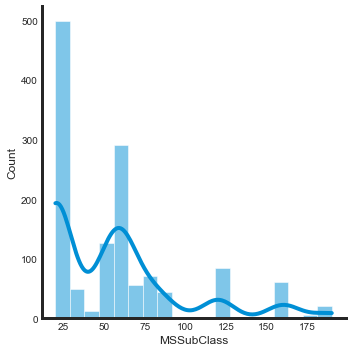

<Figure size 432x288 with 0 Axes>

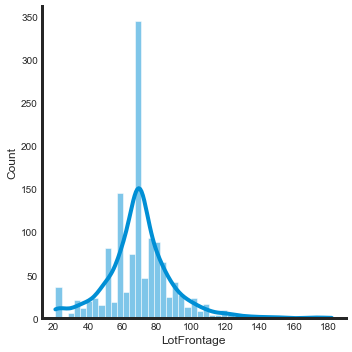

<Figure size 432x288 with 0 Axes>

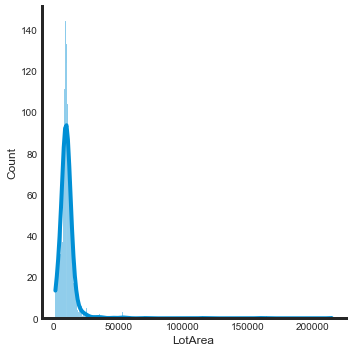

<Figure size 432x288 with 0 Axes>

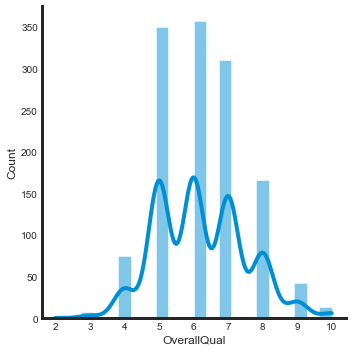

<Figure size 432x288 with 0 Axes>

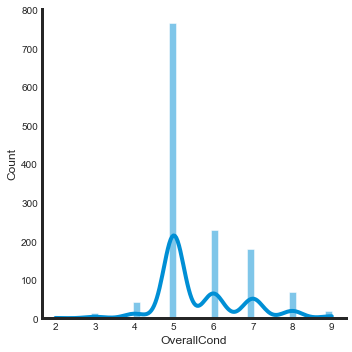

<Figure size 432x288 with 0 Axes>

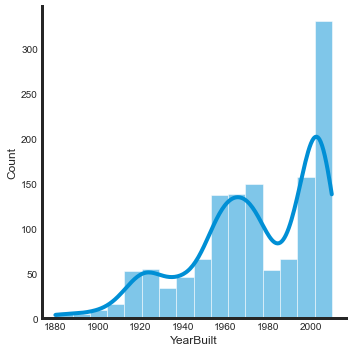

<Figure size 432x288 with 0 Axes>

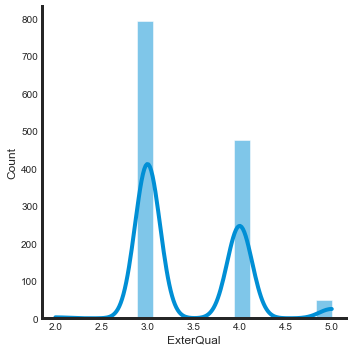

<Figure size 432x288 with 0 Axes>

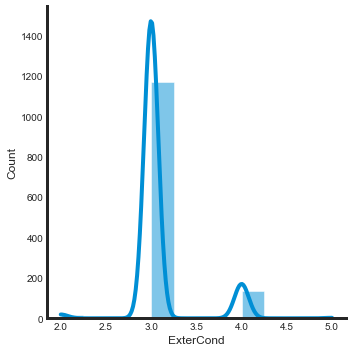

<Figure size 432x288 with 0 Axes>

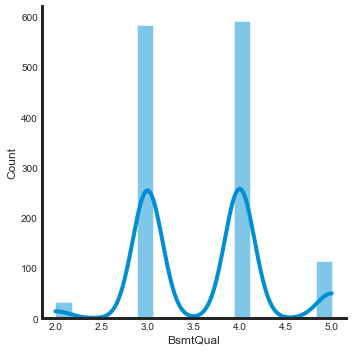

<Figure size 432x288 with 0 Axes>

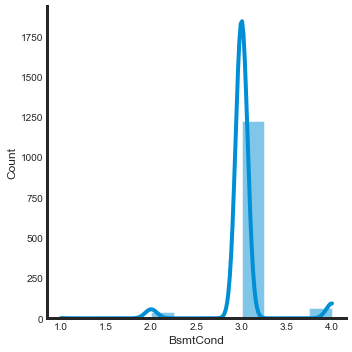

<Figure size 432x288 with 0 Axes>

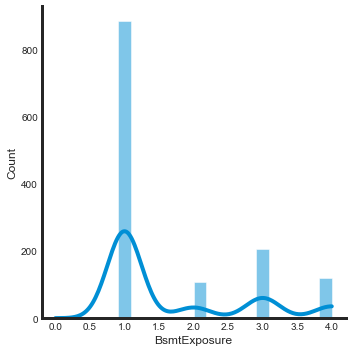

<Figure size 432x288 with 0 Axes>

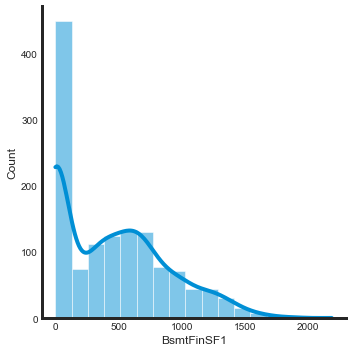

<Figure size 432x288 with 0 Axes>

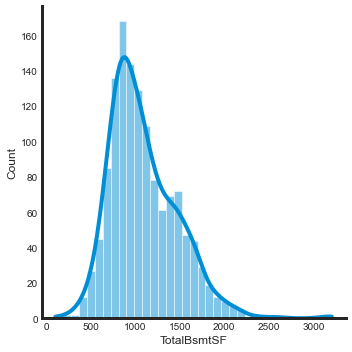

<Figure size 432x288 with 0 Axes>

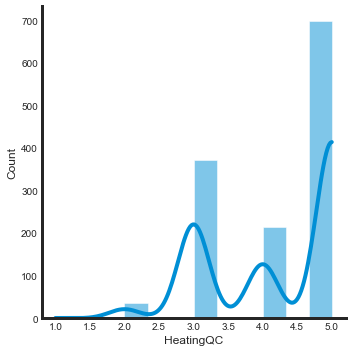

<Figure size 432x288 with 0 Axes>

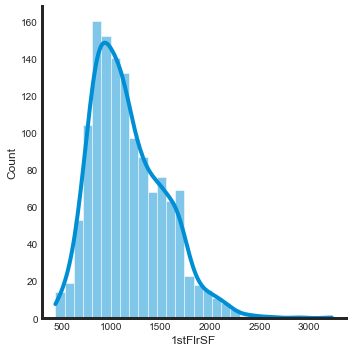

<Figure size 432x288 with 0 Axes>

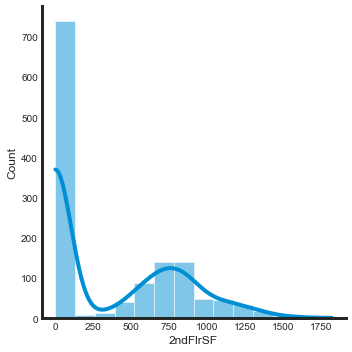

<Figure size 432x288 with 0 Axes>

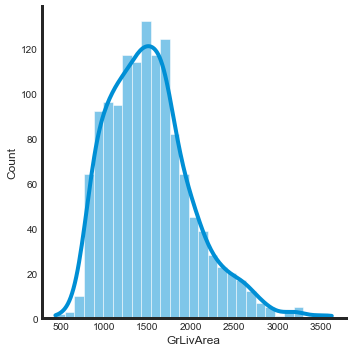

<Figure size 432x288 with 0 Axes>

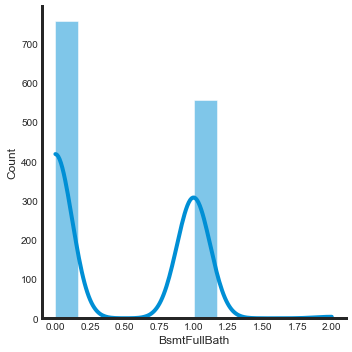

<Figure size 432x288 with 0 Axes>

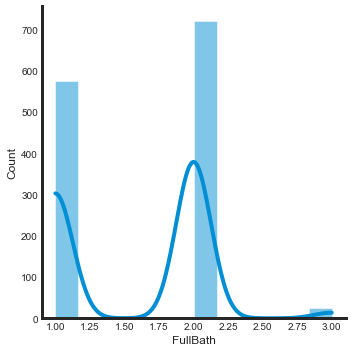

<Figure size 432x288 with 0 Axes>

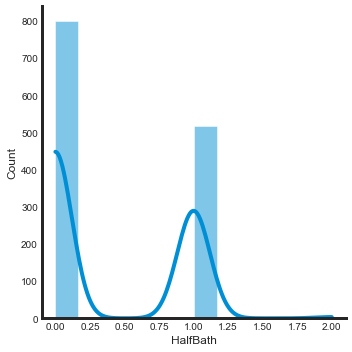

<Figure size 432x288 with 0 Axes>

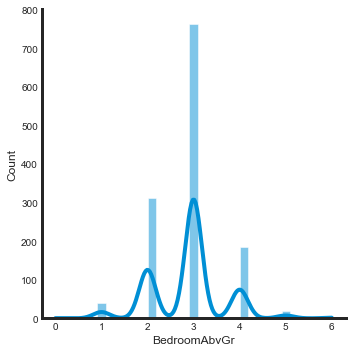

<Figure size 432x288 with 0 Axes>

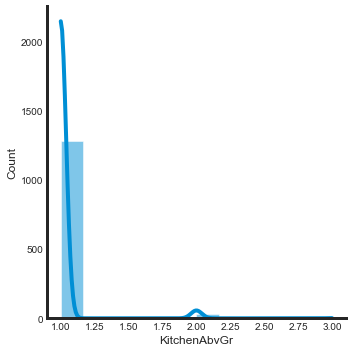

<Figure size 432x288 with 0 Axes>

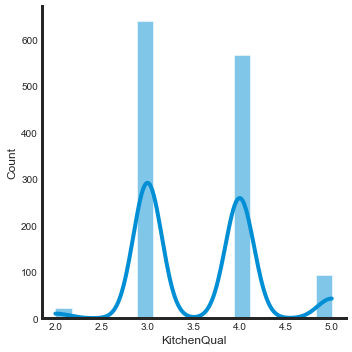

<Figure size 432x288 with 0 Axes>

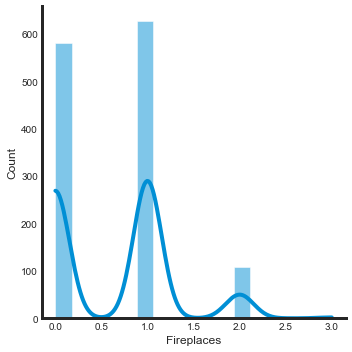

<Figure size 432x288 with 0 Axes>

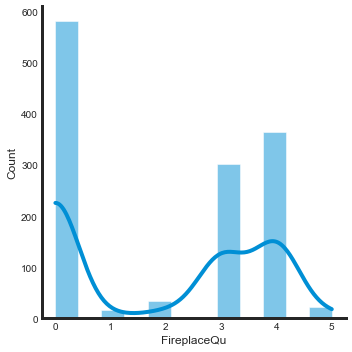

<Figure size 432x288 with 0 Axes>

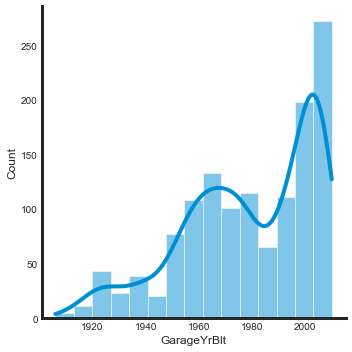

<Figure size 432x288 with 0 Axes>

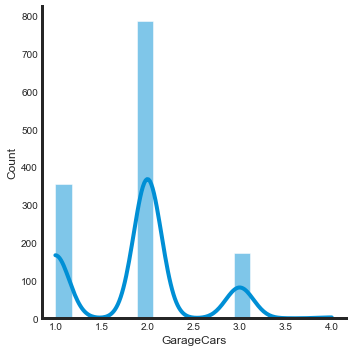

<Figure size 432x288 with 0 Axes>

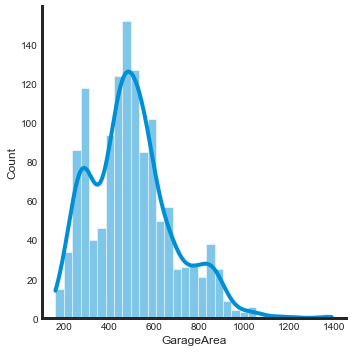

<Figure size 432x288 with 0 Axes>

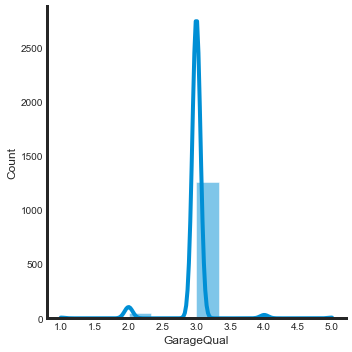

<Figure size 432x288 with 0 Axes>

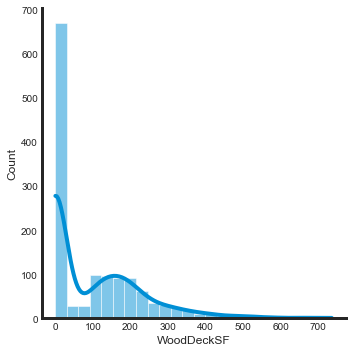

<Figure size 432x288 with 0 Axes>

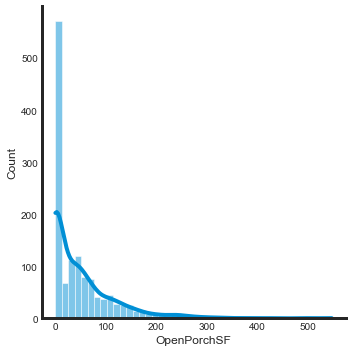

<Figure size 432x288 with 0 Axes>

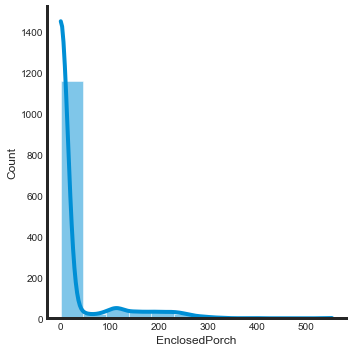

<Figure size 432x288 with 0 Axes>

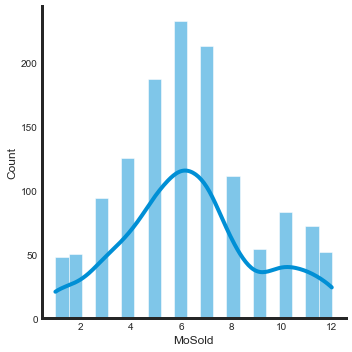

<Figure size 432x288 with 0 Axes>

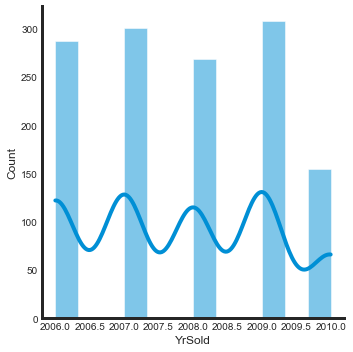

<Figure size 432x288 with 0 Axes>

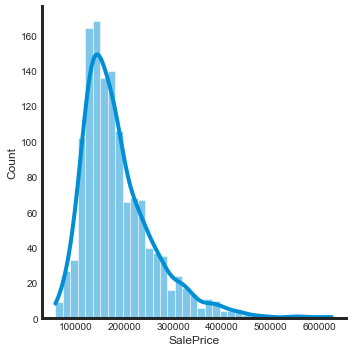

In [323]:
# Plotting the distributions of relevant columns to take a quick look at what the entries say
# about individual column.
to_plot = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
            'ExterQual' , 'ExterCond' , 'BsmtQual' , 'BsmtCond', 'BsmtExposure', 
           'BsmtFinSF1','TotalBsmtSF', 'HeatingQC',
           '1stFlrSF', '2ndFlrSF', 'GrLivArea','BsmtFullBath', 'FullBath', 
           'HalfBath' , 'BedroomAbvGr' ,'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
           'GarageQual', 'WoodDeckSF' , 'OpenPorchSF', 'EnclosedPorch' , 'MoSold' ,'YrSold' , 
           'SalePrice']

for column in to_plot:
    try:
        plt.figure()
        sns.displot(dfviz[column], kde=True)
    except:
        pass

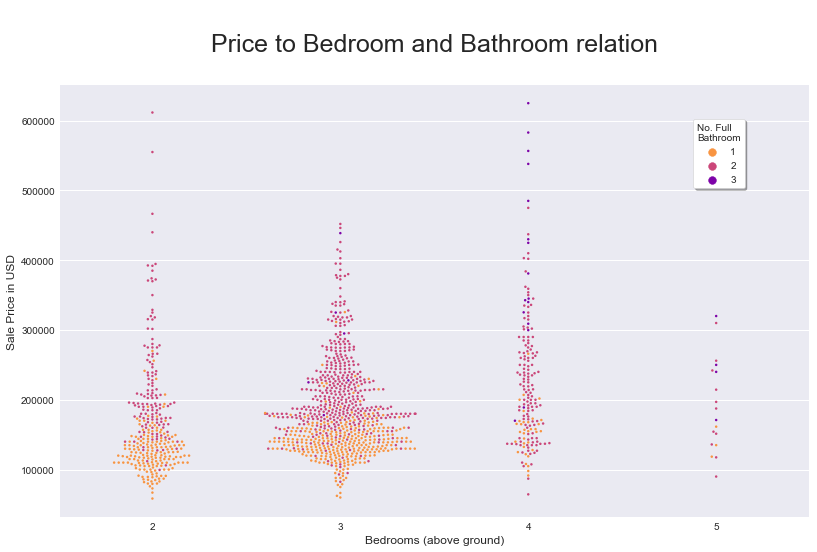

In [324]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
swarm = sns.swarmplot(x='BedroomAbvGr', y='SalePrice', data = dfviz, hue='FullBath', 
            palette='plasma_r', size=2.5)
plt.xlim(1.5,5.5)
plt.xlabel('Bedrooms (above ground)')
plt.ylabel('Sale Price in USD')
swarm.legend(title='No. Full\nBathroom', shadow=True, facecolor='white', bbox_to_anchor= (.92,.93))
plt.title('\nPrice to Bedroom and Bathroom relation\n', size=25);

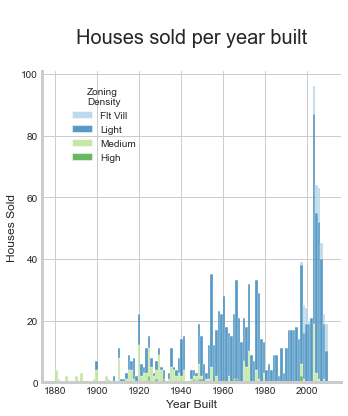

In [325]:
sns.set_style('whitegrid')
dis = sns.displot(x='YearBuilt', data=dfviz, bins= len(dfviz['YearBuilt'].value_counts()), 
                  hue='MSZoning', hue_order=['FV', 'RL', 'RM', 'RH'], multiple='stack',
                 palette='Paired')
plt.ylabel('Houses Sold')
plt.xlabel('Year Built')
plt.title('\nHouses sold per year built\n', size=20)
dis._legend.set_title('Zoning\nDensity')
new_labels = ['Flt Vill', 'Light', 'Medium' , 'High']
for t, l in zip(dis._legend.texts, new_labels): t.set_text(l)
dis._legend.set_bbox_to_anchor([0.35,0.81])
plt.show()

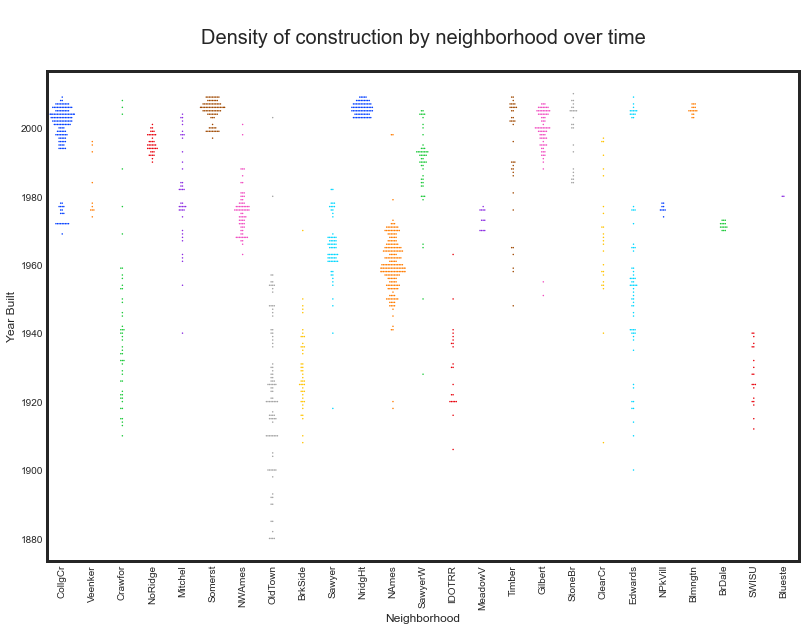

In [326]:
plt.figure(figsize=(12,9))
sns.set_style('ticks')
neighswarm = sns.swarmplot(x='Neighborhood', y='YearBuilt', data=dfviz, size=1.5, palette='bright')
plt.xticks(rotation='vertical')
plt.title('\nDensity of construction by neighborhood over time\n', size=20)
plt.ylabel('Year Built')
plt.show()

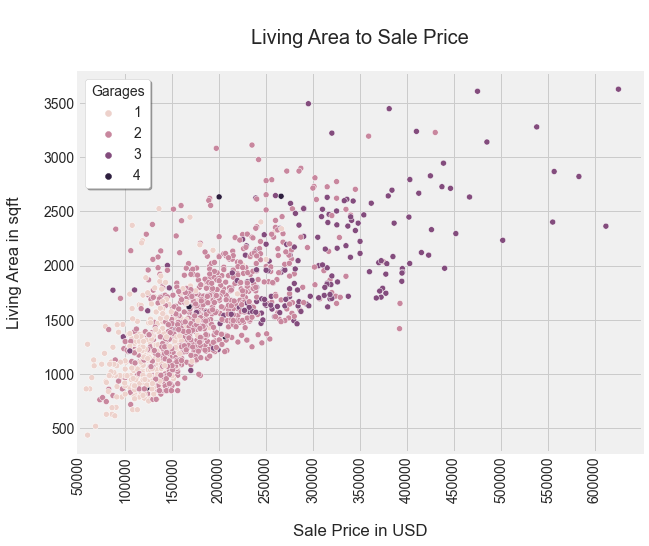

In [327]:
plt.figure(figsize=(9,7))
plt.style.use('fivethirtyeight')
scatter = sns.scatterplot(x='SalePrice', y='GrLivArea', data=dfviz, hue='GarageCars')
plt.xticks(np.arange(0, max(dfviz.SalePrice)+1, 50000))
plt.title('\nLiving Area to Sale Price\n', size=20)
plt.ylabel('Living Area in sqft\n')
plt.xlabel('\nSale Price in USD')
plt.xticks(rotation='vertical')
scatter.legend(title='Garages', shadow=True, facecolor='white')
scatter.set_xlim(left=50000, right= 650000);

#### Part 3: Feature Creation

In [328]:
dfvali = dftrain

In [329]:
"""    FEATURE CREATION    """

### MSZoning ###
#Creating a feature 'residential_den' to quantitatively record high, medium and low density.
#Potential introduction of error since we are assuming a relation/preference of low density to high.
dftrain.MSZoning.replace(['RH','RM','RL', 'RP', 'FV'], [2, 1, 0, 0, 0], inplace=True)


### LotShape ###
### LandContour ###
### Neighborhood : Physical lcoations within Ames city limits ###
### Condition1 : Proximity to various conditions ###
### BldgType : Type of dwelling ###
### HouseStyle : Style of dwelling ###
### RoofStyle : Type of roof ###
    #If model needs some bias, this is a potential drop.
### Exterior1st : Exterior covering on house ###
### Exterior2nd : Exterior covering on house (if more than one material) ###
### MasVnrType : Masonry veneer type ###
### Foundation : Type of foundation ###
### MoSold : Month Sold (MM) ###
#Produce and append dummies to convert hard-to-compare entries into logistical features
LandContourdumms = pd.get_dummies(dftrain.LandContour, prefix='LandContour')
Neighborhooddumms = pd.get_dummies(dftrain.Neighborhood, prefix='nghood')
Condition1dumms = pd.get_dummies(dftrain.Condition1, prefix='con1')
BldgTypedumms = pd.get_dummies(dftrain.BldgType, prefix='BldgType')
HouseStyledumms = pd.get_dummies(dftrain.HouseStyle, prefix='HouseStyle')
RoofStyledumms = pd.get_dummies(dftrain.RoofStyle, prefix='RfStyle')
Ext1dumms = pd.get_dummies(dftrain.Exterior1st, prefix='Ext1')
Ext2dumms = pd.get_dummies(dftrain.Exterior2nd, prefix='Ext2')
MasVnrTypedumms = pd.get_dummies(dftrain.MasVnrType, prefix='MasVnrType')
Foundationdumms = pd.get_dummies(dftrain.Foundation, prefix='Found')
MoSolddumms = pd.get_dummies(dftrain.MoSold, prefix='MoSold')


### LotConfig ###
#Combine the entries for 'Frontage on 2' and '3 sides of the property' together as there are too few FR3 and the value of the data can be preserved as a 'multi frontage' property.
dftrain.LotConfig = dftrain.LotConfig.replace('FR3', 'FR2')
LotConfigdumms = pd.get_dummies(dftrain.LotConfig, prefix='LotConfig')


### BsmtFinType1 : Rating of basement finished area ###
#Assigning NBas for No Basement, to the current np.nan's. There's no conflict since it'll be used for dummies and dropped as k - 1 control
dftrain.BsmtFinType1.replace(np.nan, 'NBas', inplace=True)
BsmtFindumms = pd.get_dummies(dftrain.BsmtFinType1, prefix='BsmtFin')


### LandSlope ###
#Encode the entries in a quantitative way, higher value = more slope. While potentially introducing error, it preserves most of its relationship
# dftrain.LandSlope.replace(['Gtl','Mod','Sev'], [0, 1, 2], inplace=True)

### GarageType : Garage location ###
#Assiging categorical value to 'no garage', and turning to dummies. 
dftrain.GarageType.replace(np.nan, 'NoGar', inplace=True)
GarageTypedumms = pd.get_dummies(dftrain.GarageType, prefix='Garage')


### GarageYrBlt : Year garage was built ###
#Dropping because of the pontential error from date data and np.nans. Value from garages is recorded elsewhere
dftrain.drop('GarageYrBlt', axis=1, inplace=True)


### GarageFinish : Interior finish of the garage ###
#Assiging categorical value to 'no garage', and turning to dummies. 
dftrain.GarageFinish.replace(np.nan, 'NoGar', inplace=True)
GarageFinishdumms = pd.get_dummies(dftrain.GarageFinish, prefix='GarFin')


### YrSold : Year Sold (YYYY) ###
#Creating a feature that tracks the age of the property by subtracting the year built from year sold.
dftrain['Prop_Age'] =  dftrain.YrSold - dftrain.YearBuilt


""" CLEAN UP """                                              
        
#Dropping all the raw variables that were converted to features
dftrain.drop(['MSSubClass', 'LandContour', 'LotConfig', 'Neighborhood',
             'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 
              'MasVnrType', 'Foundation', 'BsmtFinType1', 'GarageType', 'GarageFinish',
              'MoSold'], axis=1, inplace=True)

#Concatenating all dummies into DataFrame
dftrain = pd.concat([dftrain, LandContourdumms, LotConfigdumms, Neighborhooddumms, 
                    Condition1dumms, BldgTypedumms, HouseStyledumms, RoofStyledumms, Ext1dumms, 
                     Ext2dumms, MasVnrTypedumms, Foundationdumms, BsmtFindumms, GarageTypedumms,
                    GarageFinishdumms, MoSolddumms], axis=1)

#Dropping one variable from every dummy created in accordance with the k - 1 principle. 
#Dropping highest response dummy, if no common sense alternative exists (i.e. one of the responses can be interpreted as a zero)
dftrain.drop(['LandContour_Lvl', 'LotConfig_Inside', 'nghood_Blueste', 'con1_Norm',
              'BldgType_1Fam', 'HouseStyle_1Story', 'RfStyle_Gable', 'Ext1_VinylSd', 'Ext2_VinylSd',
             'MasVnrType_None', 'Found_PConc', 'MoSold_1','LotFrontage'], axis=1, inplace=True)


In [330]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

dfvif = dfvali.drop(['1stFlrSF','GarageCond', 'ExterCond', 'OverallCond',
                    'BsmtCond', 'GarageCars', 'YearRemodAdd', 'ExterQual', 'BsmtFinSF1',
                    'BsmtQual', '2ndFlrSF', 'GarageQual', 'TotRmsAbvGrd', 'HeatingQC',
                    'BsmtExposure', 'OverallQual', 'KitchenAbvGr', 'KitchenQual', 
                     'FireplaceQu', 'YearBuilt', 'YrSold'], axis=1)
calc_vif(dfvif)

,variables,VIF
0,MSZoning,1.554517
1,LotFrontage,16.901133
2,LotArea,2.478114
3,TotalBsmtSF,19.305362
4,GrLivArea,57.167483
5,BsmtFullBath,2.028467
6,FullBath,21.345021
7,HalfBath,2.881641
8,BedroomAbvGr,25.505383
9,Fireplaces,2.885795


#### Part 4: Modeling

In [331]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

#Get the data ready for modeling
y = dftrain.SalePrice
X = dftrain.drop(['SalePrice'], axis=1)

# Define model
model = XGBRegressor()

In [332]:
X.head()

,MSZoning,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,YrSold,Prop_Age,LandContour_Bnk,LandContour_HLS,LandContour_Low,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,nghood_Blmngtn,nghood_BrDale,nghood_BrkSide,nghood_ClearCr,nghood_CollgCr,nghood_Crawfor,nghood_Edwards,nghood_Gilbert,nghood_IDOTRR,nghood_MeadowV,nghood_Mitchel,nghood_NAmes,nghood_NPkVill,nghood_NWAmes,nghood_NoRidge,nghood_NridgHt,nghood_OldTown,nghood_SWISU,nghood_Sawyer,nghood_SawyerW,nghood_Somerst,nghood_StoneBr,nghood_Timber,nghood_Veenker,con1_Artery,con1_Feedr,con1_PosA,con1_PosN,con1_RRAe,con1_RRAn,con1_RRNe,con1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RfStyle_Flat,RfStyle_Gambrel,RfStyle_Hip,RfStyle_Mansard,RfStyle_Shed,Ext1_AsbShng,Ext1_BrkComm,Ext1_BrkFace,Ext1_CBlock,Ext1_CemntBd,Ext1_HdBoard,Ext1_ImStucc,Ext1_MetalSd,Ext1_Plywood,Ext1_Stone,Ext1_Stucco,Ext1_Wd Sdng,Ext1_WdShing,Ext2_AsbShng,Ext2_AsphShn,Ext2_Brk Cmn,Ext2_BrkFace,Ext2_CBlock,Ext2_CmentBd,Ext2_HdBoard,Ext2_ImStucc,Ext2_MetalSd,Ext2_Other,Ext2_Plywood,Ext2_Stone,Ext2_Stucco,Ext2_Wd Sdng,Ext2_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,Found_BrkTil,Found_CBlock,Found_Stone,Found_Wood,BsmtFin_ALQ,BsmtFin_BLQ,BsmtFin_GLQ,BsmtFin_LwQ,BsmtFin_Rec,BsmtFin_Unf,Garage_2Types,Garage_Attchd,Garage_Basment,Garage_BuiltIn,Garage_CarPort,Garage_Detchd,GarFin_Fin,GarFin_RFn,GarFin_Unf,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,0,8450,7,5,2003,2003,4,3,4,3,1,706,856,5,856,854,1710,1,2,1,3,1,4,8,0,0,2,548,3,3,0,61,0,2008,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,0,9600,6,8,1976,1976,3,3,4,3,4,978,1262,5,1262,0,1262,0,2,0,3,1,3,6,1,3,2,460,3,3,298,0,0,2007,31,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,11250,7,5,2001,2002,4,3,4,3,2,486,920,5,920,866,1786,1,2,1,3,1,4,6,1,3,2,608,3,3,0,42,0,2008,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,9550,7,5,1915,1970,3,3,3,4,1,216,756,4,961,756,1717,1,1,0,3,1,4,7,1,4,3,642,3,3,0,35,272,2006,91,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,14260,8,5,2000,2000,4,3,4,3,3,655,1145,5,1145,1053,2198,1,2,1,4,1,4,9,1,3,3,836,3,3,192,84,0,2008,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [333]:
# Splitting the data into test and train dfs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # df = independent variables, y = dependent variables, 0.3 = 30%

# Fitting Model
model.fit(X_train, y_train)

# Define evaluation method
cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=42)

# Evaluate model
scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
scores.mean()

0.8807219874770357

In [334]:
yhat = model.predict(X_test)

print("The model's R squared score is "+str(r2_score(y_test, yhat)))


The model's R squared score is 0.8804126231406093


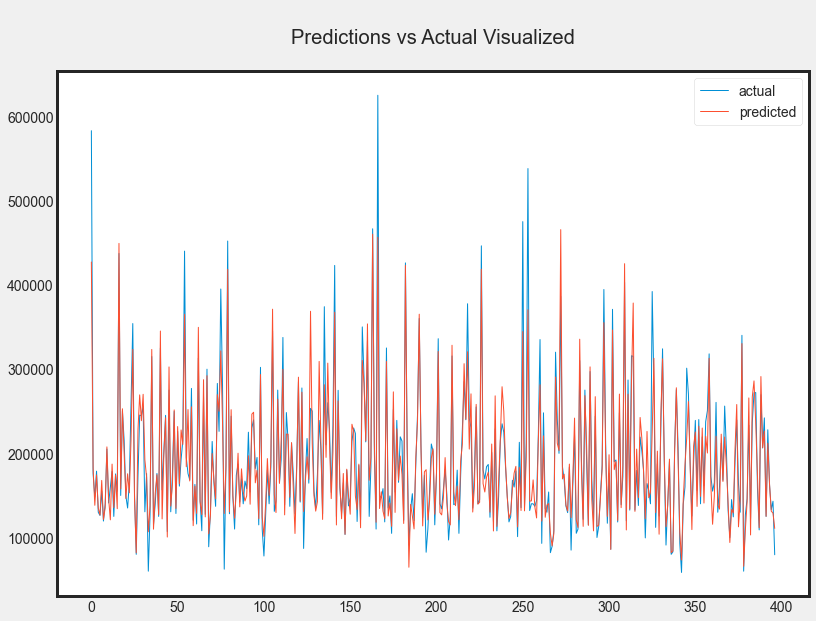

In [335]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,9))
sns.set_style('ticks')
plt.plot(x_ax, y_test, label='actual', linewidth=1)
plt.plot(x_ax, yhat, label='predicted', linewidth=1)
plt.title('\nPredictions vs Actual Visualized\n')
plt.legend()
plt.show()

In [336]:
# Linear model
lm = LinearRegression()

In [337]:
lm.fit(X_train, y_train)

# Define evaluation method
lmcv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=42)

# Evaluate model
lmscores = cross_val_score(lm, X, y, cv=lmcv, n_jobs=-1)
lmscores.mean()

0.8851758146765216

In [338]:
lmyhat= lm.predict(X_test)

print("The linear model's R squared score is "+str(r2_score(y_test, lmyhat)))

The linear model's R squared score is 0.8778299762484095


In [339]:
len(lm.coef_)

150

In [340]:
coeffs = pd.DataFrame(columns=['Variable', 'Coefficient', 'Raw'])
coeffs.Variable= X_train.columns
coeffs.Coefficient = abs(lm.coef_)
coeffs.Raw = lm.coef_
coeffs.round(2).sort_values(by='Coefficient', ascending=False)

,Variable,Coefficient,Raw
62,nghood_StoneBr,41589.74,41589.74
99,Ext1_Stucco,39622.54,39622.54
75,BldgType_Twnhs,37584.51,-37584.51
102,Ext2_AsbShng,35611.25,-35611.25
114,Ext2_Stucco,35254.97,-35254.97
56,nghood_NridgHt,32080.49,32080.49
116,Ext2_Wd Shng,30926.31,-30926.31
89,Ext1_AsbShng,29862.93,29862.93
107,Ext2_CmentBd,28935.72,28935.72
88,RfStyle_Shed,28913.28,-28913.28


In [341]:
dforigin.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,GLQ,706,Unf,0,150,856,GasA,5,1,4.0,856,854,0,1710,1,0,2,1,3,1,4,8,0,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,ALQ,978,Unf,0,284,1262,GasA,5,1,4.0,1262,0,0,1262,0,1,2,0,3,1,3,6,0,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,GLQ,486,Unf,0,434,920,GasA,5,1,4.0,920,866,0,1786,1,0,2,1,3,1,4,6,0,1,3,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,ALQ,216,Unf,0,540,756,GasA,4,1,4.0,961,756,0,1717,1,0,1,0,3,1,4,7,0,1,4,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,GLQ,655,Unf,0,490,1145,GasA,5,1,4.0,1145,1053,0,2198,1,0,2,1,4,1,4,9,0,1,3,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
def 
#Coding the ranked qualitative response into a quantitative, aka A,B,C become 3,2,1
scale_from_6 = sorted(list(range(6)), reverse=True)
rating_from_top = ['Ex','Gd','TA','Fa','Po', np.nan]
vars_to_scale = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

for i in vars_to_scale:
    dftrain[i].replace(rating_from_top, scale_from_6, inplace=True)


### BsmtExposure : Refers to walkout or garden level walls ###
#Coding rating to numeric
dftrain.BsmtExposure.replace(['Gd','Av','Mn','No', np.nan], [4, 3, 2, 1, 0], inplace=True)


### CentrailAir : Central air conditioning ###
#Converting to logistical response
dftrain.CentralAir.replace(['Y','N'], [1,0], inplace=True)


### Electrical : Electrical system ###
#Coding quality of electrical system on a scale. Potential introduction of error. Consider using dummies instead
dftrain.Electrical.replace(['SBrkr','FuseA','FuseF','FuseP','Mix'], [4, 3, 2, 1, 0], inplace=True)


### Functional : Home functionality (Assume typical unless deductions are warranted)  ###
#Coding to numeric scale, with 0 being normal and increasing as functionality worsens
dftrain.Functional.replace(['Sal', 'Sev', 'Maj2', 'Maj1','Mod','Min2','Min1','Typ'], 
                           [7, 6, 5, 4, 3, 2, 1, 0], inplace=True)


#Dropping columns with too many same/missing or null values, as well as the ID since it carries no insights
dftrain = dftrain.drop(['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'Utilities', 'Id', 'Street', 
                        'PavedDrive', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
                        'SaleType', 'SaleCondition', 'LowQualFinSF', 'BsmtFinType2', 
                        'BsmtUnfSF',  'Heating', 'RoofMatl', 'Condition2', 'MasVnrArea', 
                        'Functional', 'BsmtFinSF2', 'CentralAir', 'Electrical', 
                        'BsmtHalfBath', 'LandSlope', 'LotShape'], axis=1)   

#Dropping entries for commercial properties, the top 4 outliers based on the distribution 
#of GrLivArea, and resetting index for analysis
index_todrop = dftrain.loc[dftrain.MSZoning == 'C (all)'].index
index_todrop = index_todrop.append(dftrain.loc[dftrain.GrLivArea >= 4000].index)
index_todrop = index_todrop.append(dftrain.loc[dftrain.LotFrontage >= 200].index)
index_todrop = index_todrop.append(dftrain.loc[dftrain.FullBath < 1].index)

dftrain.drop(index_todrop, inplace=True)